In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from snakeAI import SnakeGameAI, Direction, Point
from model import Linear_QNet, QTraining, get_device
from IPython import display


# Check PyTorch version
pt_version = torch.__version__
with open("configs.txt", "w") as f:
    f.write(f"[INFO] Current PyTorch version: {pt_version}")

# Write PyTorch version to file
with open("configs.txt", "a") as f:
    f.write(f"PyTorch version: {pt_version}")

if torch.cuda.is_available():
    gpu_info = !nvidia-smi #type: ignore
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find("failed") >= 0:
        with open("configs.txt", "a") as f:
            f.write("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

    # Get GPU name
    gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv #type: ignore
    gpu_name = gpu_name[1]
    GPU_NAME = gpu_name.replace(" ", "_")  # remove underscores for easier saving
    with open("configs.txt", "a") as f:
        f.write(f'\nGPU name: {GPU_NAME}')

    # Get GPU capability score
    GPU_SCORE = torch.cuda.get_device_capability()
    print(f"GPU capability score: {GPU_SCORE}")
    if GPU_SCORE >= (8, 0):
        with open("configs.txt", "a") as f:
            f.write("GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
    else:
        with open("configs.txt", "a") as f:
            f.write("GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

    # Print GPU info
    with open("configs.txt", "a") as f:
        f.write(f"\nGPU information:\n{gpu_info}")

else:
    with open("configs.txt", "a") as f:
        f.write("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")


with open("configs.txt", "a") as f:
    f.write(f"\nTorchVision version: {torchvision.__version__}")
    f.write(f"\nNumPy version: {np.__version__}")
    f.write(f"\nMatplotlib version: {plt.matplotlib.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

with open("configs.txt", "a") as f:
    f.write(f"\nUsing device: {device}")
    
print(get_device())

pygame 2.4.0 (SDL 2.26.4, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
GPU capability score: (7, 5)
cuda


<Figure size 640x480 with 0 Axes>

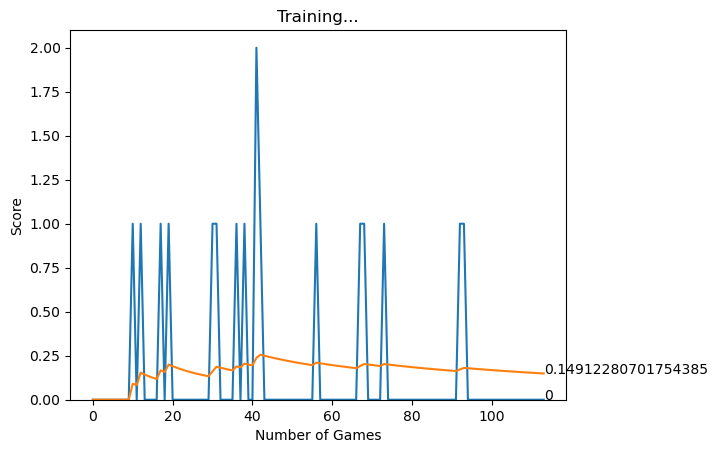

NameError: name 'quit' is not defined

In [2]:
# defult hyperparameters
LR = 0.001
BATCH_SIZE = 10000
MAX_MEMORY = 1000

# Agent
class AGENT:
    def __init__(self):
        self.number_of_games = 0
        self.epsilon = 0
        self.GAMMA = 0.8
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = Linear_QNet(11, 256, 256, 3)
        gpu = torch.device("cuda:0")
        self.model.to('cuda')
        self.trainer = QTraining(self.model , lr=LR, gamma=self.GAMMA)
        self.last_move = [1, 0, 0]  # Store the last move made by the agent
    
    def get_state(self,game):
        # there are 11 values
        
        # create 4 points around head
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)
        
        # check current direction is in one of those (out of 4 one will be bool)
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN
    
        state = [
            # danger_straight
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or  
            (dir_u and game.is_collision(point_u)) or
            (dir_d and game.is_collision(point_d)),
            
            # dange_right
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or
            (dir_l and game.is_collision(point_u)) or
            (dir_r and game.is_collision(point_d)),
            
            # danger left
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or
            (dir_r and game.is_collision(point_u)) or
            (dir_l and game.is_collision(point_d)),
            
            # move direction (one is true others are false)
            dir_l, dir_r, dir_u, dir_d,
            
            # food location 
            game.food.x < game.head.x, # food is located on left
            game.food.x > game.head.x, # food is located on right
            game.food.y < game.head.y, # food is located on up
            game.food.y > game.head.y, # food is located on down
        ]
        
        return np.array(state, dtype=int)
    
    def remember_brain(self,state,action,reward,next_state,is_done):
        self.memory.append((state,action,reward,next_state,is_done))
    
    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)
        else:
            mini_sample = self.memory
          
        self.trainer.train_step(*(zip(*mini_sample)))
    
    def train_short_memory(self,state,action,reward,next_state,is_done):
        self.trainer.train_step(state,action,reward,next_state,is_done)
    
    def action_state(self, state):
        self.epsilon = 100 - self.number_of_games
        final_move = [0, 0, 0]

        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0.cuda())
            move = torch.argmax(prediction).item()
            final_move[move] = 1            

        return final_move
    
    
plt.ion()
def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)
    
def train():
    scores_plot = []
    plot_mean_scores = []
    total_score = 0 
    record = 0
    agent = AGENT()
    game = SnakeGameAI()
    
    
    # Check if a saved model exists and load it
    if agent.model.load_checkpoint():
        print("Checkpoint found. Resuming training...")
    else:
        print("No checkpoint found. Starting from scratch...")
    
    while True:
        # old state
        state_old = agent.get_state(game)
        
        # moves
        final_move = agent.action_state(state_old)
        
        # perform move
        reward, done, score = game.play_step(final_move)
        new_state = agent.get_state(game)
        
        # short term memory
        agent.train_short_memory(state_old,final_move,reward, new_state,done)
        
        # remember
        agent.remember_brain(state_old,final_move,reward, new_state,done)
        
        
        if done:
            # train experience replay, plot result
            game.reset()
            agent.number_of_games += 1
            agent.train_long_memory()
            
            if score > record:
                record = score
                agent.model.save()
                
            # print game score record 
            print("Game number" + str(agent.number_of_games),'Score',score, "Record", record)
            
            # plot the outputs
            scores_plot.append(score)
            total_score += score
            mean_score = total_score / agent.number_of_games
            plot_mean_scores.append(mean_score)
            plot(scores_plot, plot_mean_scores)
            
            # Save the model's state every 1000 steps
            if agent.number_of_games % 1000 == 0:
                agent.model.save_checkpoint()
            
if __name__ == "__main__":
    train()
    